In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import paleoscripts as ps

In [2]:
#files = []
# for case in ['3601-3700', '3701-3800', '3801-3900', '3901-4000']:
#     files.append('/home/alhafisu/nobackup/41ka1/' + case + '/srnd_41ka1.nc.gz')

lon_min, lon_max = 140, 155 ## 130., 140. # 140, 155
lat_min, lat_max = 0, 30 # -10., 30.

import glob
files = glob.glob('/nesi/nobackup/vuw03367/hos03/??01-??00/srnd*.nc.gz')
files.sort()
ds = xr.open_mfdataset(files)
files

['/nesi/nobackup/vuw03367/hos03/5001-5100/srnd_hos03.nc.gz',
 '/nesi/nobackup/vuw03367/hos03/5101-5200/srnd_hos03.nc.gz',
 '/nesi/nobackup/vuw03367/hos03/5201-5300/srnd_hos03.nc.gz',
 '/nesi/nobackup/vuw03367/hos03/5301-5400/srnd_hos03.nc.gz',
 '/nesi/nobackup/vuw03367/hos03/5401-5500/srnd_hos03.nc.gz']

In [3]:
ds.rnd

<xarray.DataArray 'rnd' (year: 500, month: 12, latitude: 56, longitude: 64)>
dask.array<concatenate, shape=(500, 12, 56, 64), dtype=float32, chunksize=(100, 12, 56, 64), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -87.56 -84.4 -81.22 ... 81.22 84.4 87.56
  * longitude  (longitude) float32 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * month      (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * year       (year) int64 5001 5002 5003 5004 5005 ... 5497 5498 5499 5500
Attributes:
    long_name:  precipitation
    units:      mm/day

In [4]:
# pad
rnd_coarse = ps.apply_cyclic_padding(ds.rnd)
rnd_coarse

<xarray.DataArray 'rnd' (year: 500, month: 12, latitude: 56, longitude: 65)>
array([[[[1.37280390e-01, 1.27297327e-01, 1.17281392e-01, ...,
          1.58361599e-01, 1.47567838e-01, 1.37280390e-01],
         [1.75025806e-01, 1.69773847e-01, 1.57034278e-01, ...,
          1.70377925e-01, 1.76409528e-01, 1.75025806e-01],
         [1.24514997e-01, 1.14795446e-01, 1.02051944e-01, ...,
          1.08985163e-01, 1.37210146e-01, 1.24514997e-01],
         ...,
         [1.50484300e+00, 1.55261123e+00, 1.40941978e+00, ...,
          1.02600825e+00, 1.34316492e+00, 1.50484300e+00],
         [1.23920691e+00, 1.20662117e+00, 1.08332193e+00, ...,
          9.93616581e-01, 1.22277713e+00, 1.23920691e+00],
         [7.18151212e-01, 6.98793709e-01, 6.72817171e-01, ...,
          7.26972163e-01, 7.32035160e-01, 7.18151212e-01]],

        [[3.15923733e-03, 2.19858065e-03, 1.69037888e-03, ...,
          1.09912669e-02, 7.10731698e-03, 3.15923733e-03],
         [1.05232429e-02, 6.48371037e-03, 3.75575689e-03, ...,
          1.55784450e-02, 1.21157123e-02, 1.05232429e-02],
         [1.07891195e-01, 8.13803747e-02, 5.33270687e-02, ...,
          1.63037851e-01, 1.37094647e-01, 1.07891195e-01],
...
          4.63986516e-01, 5.18148839e-01, 5.33459842e-01],
         [9.38606322e-01, 9.73664284e-01, 1.04408824e+00, ...,
          7.78351605e-01, 8.61289501e-01, 9.38606322e-01],
         [9.83809710e-01, 1.09208071e+00, 1.10388112e+00, ...,
          7.27093637e-01, 8.37901235e-01, 9.83809710e-01]],

        [[6.89212903e-02, 6.82274550e-02, 6.64694235e-02, ...,
          7.43535906e-02, 7.09218457e-02, 6.89212903e-02],
         [6.62295669e-02, 5.46939448e-02, 4.68188189e-02, ...,
          7.50128776e-02, 7.38379806e-02, 6.62295669e-02],
         [1.85329139e-01, 1.58759981e-01, 1.15171462e-01, ...,
          1.81226894e-01, 1.98287025e-01, 1.85329139e-01],
         ...,
         [5.57050347e-01, 6.77953064e-01, 7.64562786e-01, ...,
          1.72951922e-01, 3.40308785e-01, 5.57050347e-01],
         [6.58501923e-01, 6.75361574e-01, 6.80074811e-01, ...,
          5.29147446e-01, 6.03918552e-01, 6.58501923e-01],
         [5.01378357e-01, 6.94201767e-01, 7.61716545e-01, ...,
          2.74678856e-01, 3.67281735e-01, 5.01378357e-01]]]],
      dtype=float32)
Coordinates:
  * year       (year) int64 5001 5002 5003 5004 5005 ... 5497 5498 5499 5500
  * month      (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float32 -87.56 -84.4 -81.22 ... 81.22 84.4 87.56
  * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 348.8 354.4 360.0
Attributes:
    long_name:  precipitation
    units:      mm/day

In [6]:
# regrid to a finer grid
new_lons = np.linspace(lon_min, lon_max, 51)
new_lats = np.linspace(lat_min, lat_max, 41)
rnd = rnd_coarse.interp(longitude=new_lons, latitude=new_lats, method='cubic')

In [7]:
# seasonal means across decades, after increasing the resolution
years = rnd.year.values
year_max = years[-1]
d_year = 19
rnd_season_decade_mean = {}
for s in ('djf', 'mam', 'jja', 'son'):
    rnd_season_decade_mean[s] = {}
    y0 = years[0]
    while y0 < year_max:
        y1 = min(y0 + d_year, year_max)
        rain = ps.extract_season(rnd.sel(year=slice(y0, y1)), s)
        rnd_season_decade_mean[s][(y0, y1)] = rain.mean(dim=['year', 'month'])
        y0 = y1

In [8]:
# for each season, decade, we compute the max rain line
lines = {}
for s in rnd_season_decade_mean:
    lines[s] = {}
    for ys in rnd_season_decade_mean[s]:
        xy = ps.find_points_where_field_is_extreme(rnd_season_decade_mean[s][ys])
        lines[s][ys] = xy

['5001-5020', '5020-5039', '5039-5058', '5058-5077', '5077-5096', '5096-5115', '5115-5134', '5134-5153', '5153-5172', '5172-5191', '5191-5210', '5210-5229', '5229-5248', '5248-5267', '5267-5286', '5286-5305', '5305-5324', '5324-5343', '5343-5362', '5362-5381', '5381-5400', '5400-5419', '5419-5438', '5438-5457', '5457-5476', '5476-5495', '5495-5500']


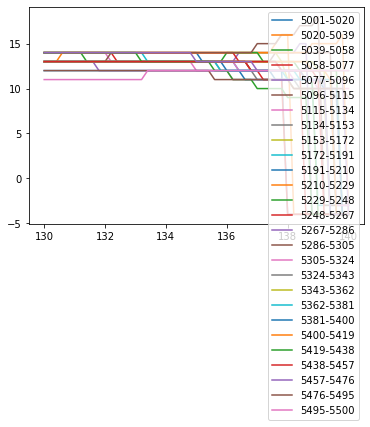

In [9]:
# plot
s = 'djf'
leg = [f'{ys[0]}-{ys[1]}' for ys in lines[s].keys()]
print(leg)
for ys in lines[s]:
    xy = lines[s][ys]
    plt.plot(xy[:, 0], xy[:, 1])
plt.legend(leg)

Text(0, 0.5, 'lat deg')

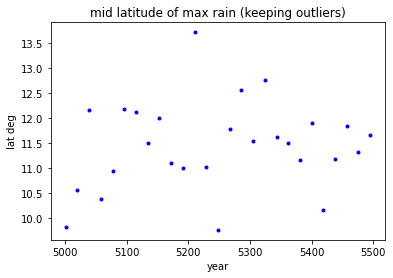

In [11]:
# compute the linear regression coefficients
from scipy.stats import linregress
# set the season
s = 'djf'
vals_ref = []
for ys in lines[s]:
    xy = lines[s][ys]
    res = linregress(xy)
    xmin, xmax = xy[:, 0].min(), xy[:, 0].max()
    xmid = 0.5*(xmin + xmax)
    latmid = res.intercept + res.slope * xmid
    vals_ref.append((ys[0], latmid, res.intercept, res.slope))
    
vals_ref = np.array(vals_ref)

plt.plot(vals_ref[:, 0], vals_ref[:, 1], 'b.')
plt.title('mid latitude of max rain (keeping outliers)')
plt.xlabel('year')
plt.ylabel('lat deg')


Text(0, 0.5, 'lat deg')

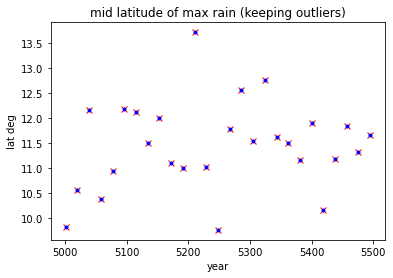

In [13]:
# now do the same thing and see if there are any differences
# set the season
s = 'djf'
vals_new = []
for ys in lines[s]:
    xy = lines[s][ys]
    res = ps.linear_regression_coeffs(xy, cooks_tol=10000.)
    xmin, xmax = xy[:, 0].min(), xy[:, 0].max()
    xmid = 0.5*(xmin + xmax)
    latmid = res.intercept + res.slope * xmid
    vals_new.append((ys[0], latmid, res.intercept, res.slope))
    
vals_new = np.array(vals_new)

plt.plot(vals_ref[:, 0], vals_ref[:, 1], 'rx')
plt.plot(vals_new[:, 0], vals_new[:, 1], 'b.')
plt.title('mid latitude of max rain (keeping outliers)')
plt.xlabel('year')
plt.ylabel('lat deg')


Text(0, 0.5, 'lat deg')

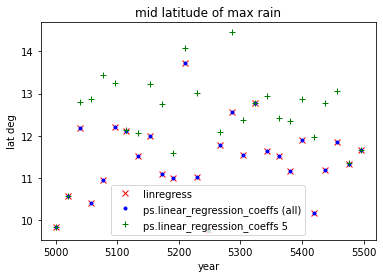

In [15]:
# now apply the default outlier removal threshold
# set the season
s = 'djf'
cook_tol = 5
vals_out = []
for ys in lines[s]:
    xy = lines[s][ys]
    res = ps.linear_regression_coeffs(xy, cooks_tol=cook_tol)
    xmin, xmax = xy[:, 0].min(), xy[:, 0].max()
    xmid = 0.5*(xmin + xmax)
    latmid = res.intercept + res.slope * xmid
    vals_out.append((ys[0], latmid, res.intercept, res.slope))
    
vals_out = np.array(vals_out)

plt.plot(vals_ref[:, 0], vals_ref[:, 1], 'rx')
plt.plot(vals_new[:, 0], vals_new[:, 1], 'b.')
plt.plot(vals_out[:, 0], vals_out[:, 1], 'g+')
plt.legend(['linregress', 'ps.linear_regression_coeffs (all)', f'ps.linear_regression_coeffs {cook_tol}'])
plt.title('mid latitude of max rain')
plt.xlabel('year')
plt.ylabel('lat deg')


In [16]:
# find case where the diff is max and investigate
vmax = np.fabs(vals_ref[:, 1] - vals_out[:, 1]).max()
i = np.where( np.fabs(vals_ref[:, 1] - vals_out[:, 1]) == vmax)[0][0]
i

4

In [17]:
vals_ref[i,:]

array([ 5.07700000e+03,  1.09411765e+01,  1.59563348e+02, -1.10090498e+00])

In [18]:
y0 = int(vals_ref[i, 0])
y1 = y0 + d_year
xy = lines[s][(y0, y1)]
x = xy[:, 0]
vals_ref[i, 2] + vals_ref[i, 3]*x

array([16.44570136, 16.22552036, 16.00533937, 15.78515837, 15.56497738,
       15.34479638, 15.12461538, 14.90443439, 14.68425339, 14.4640724 ,
       14.2438914 , 14.02371041, 13.80352941, 13.58334842, 13.36316742,
       13.14298643, 12.92280543, 12.70262443, 12.48244344, 12.26226244,
       12.04208145, 11.82190045, 11.60171946, 11.38153846, 11.16135747,
       10.94117647, 10.72099548, 10.50081448, 10.28063348, 10.06045249,
        9.84027149,  9.6200905 ,  9.3999095 ,  9.17972851,  8.95954751,
        8.73936652,  8.51918552,  8.29900452,  8.07882353,  7.85864253,
        7.63846154,  7.41828054,  7.19809955,  6.97791855,  6.75773756,
        6.53755656,  6.31737557,  6.09719457,  5.87701357,  5.65683258,
        5.43665158])

In [19]:
vals_ref[i,:]

array([ 5.07700000e+03,  1.09411765e+01,  1.59563348e+02, -1.10090498e+00])

Text(0.5, 1.0, 'case where the removal of outliers produces a notable difference')

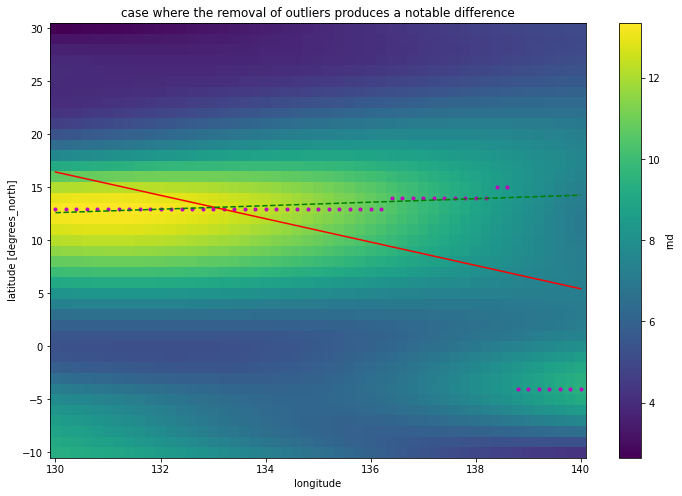

In [20]:
plt.figure(figsize=(12, 8))

rnd_season_decade_mean['djf'][(y0, y1)].plot()

xy = lines[s][(y0, y1)]
x = xy[:, 0]

plt.plot(x, xy[:, 1], 'm.')
plt.plot(x, vals_ref[i, 2] + vals_ref[i, 3]*x, 'r-')
plt.plot(x, vals_out[i, 2] + vals_out[i, 3]*x, 'g--')
plt.title('case where the removal of outliers produces a notable difference')

In [ ]:
i